<a href="https://colab.research.google.com/github/alishachandni/Anomaly-Detection/blob/main/Br35H_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import drive
import shutil

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset path
dataset_path = "/content/drive/MyDrive/Final Project/Br35H"

In [ ]:
# Image processing parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 150
LATENT_DIM = 128

In [ ]:
# Create directory for results
results_path = "/content/drive/MyDrive/Final Project/Results"
os.makedirs(results_path, exist_ok=True)

In [ ]:
# Load and preprocess images
def load_and_preprocess_images(dataset_path):
    images, labels = [], []
    for label in ["yes", "no"]:
        class_path = os.path.join(dataset_path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(0 if label == "no" else 1)  # 0 = Normal, 1 = Tumor
    return np.array(images), np.array(labels)

X, y = load_and_preprocess_images(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Encoder
def build_encoder():
    inputs = layers.Input(shape=(128, 128, 3))
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)

    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    return models.Model(inputs, [z_mean, z_log_var, z], name="Encoder")

In [ ]:
# Decoder
def build_decoder():
    inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(32 * 32 * 128, activation='relu')(inputs)
    x = layers.Reshape((32, 32, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, padding='same', activation='sigmoid')(x)
    return models.Model(inputs, x, name="Decoder")


In [ ]:
# Custom VAE Loss Layer
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, x_decoded, z_mean, z_log_var = inputs
        recon_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_decoded))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(recon_loss + kl_loss)
        return x_decoded

In [ ]:
# Compile VAE
def compile_vae(encoder, decoder):
    inputs = layers.Input(shape=(128, 128, 3))
    z_mean, z_log_var, z = encoder(inputs)
    recon_images = decoder(z)
    outputs = VAELossLayer()([inputs, recon_images, z_mean, z_log_var])
    vae = models.Model(inputs, outputs, name="VAE")
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
    return vae

In [ ]:
# Loss tracking
adversarial_losses, contextual_losses, encoder_losses, total_losses = [], [], [], []

class LossTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        adversarial_losses.append(logs.get('loss', 0))
        contextual_losses.append(logs.get('val_loss', 0))
        encoder_losses.append(logs.get('kl_loss', 0))
        total_losses.append(adversarial_losses[-1] + contextual_losses[-1])

In [ ]:
# Train VAE
encoder = build_encoder()
decoder = build_decoder()
vae = compile_vae(encoder, decoder)

vae.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, X_test), callbacks=[LossTracker()])

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.6720 - val_loss: 0.5370
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5236 - val_loss: 0.5196
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5077 - val_loss: 0.5159
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5118 - val_loss: 0.5121
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5090 - val_loss: 0.5121
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5063 - val_loss: 0.5115
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5070 - val_loss: 0.5126
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5024 - val_loss: 0.5125
Epoch 9/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5037 - val_loss: 0.5108
Epoch 10/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5037 - val_loss: 0.5114
Epoch 11/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5060 - val_loss: 0.5097
Epoch 12/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/ste

In [ ]:
# Save Losses
pd.DataFrame({
    "Epoch": range(EPOCHS),
    "Adversarial Loss": adversarial_losses,
    "Contextual Loss": contextual_losses,
    "Encoder Loss": encoder_losses,
    "Total Loss": total_losses
}).to_csv(f"{results_path}/br35h_losses.csv", index=False)

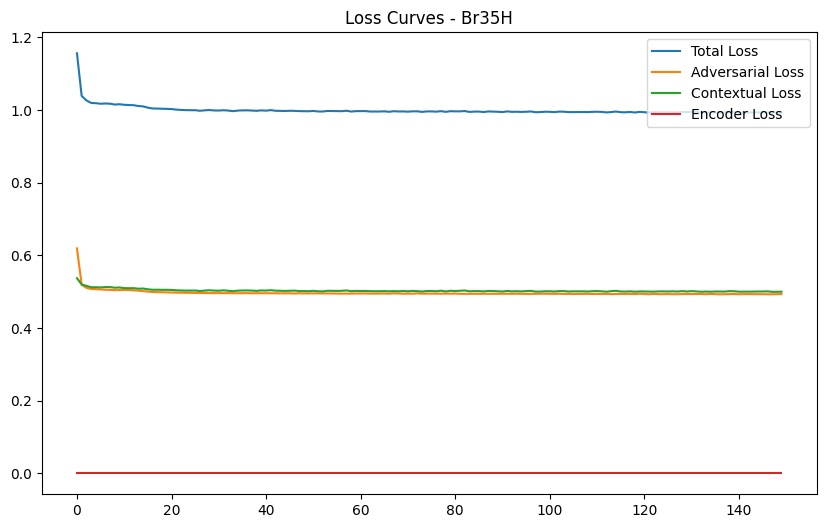

In [ ]:
# Save Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(total_losses, label="Total Loss")
plt.plot(adversarial_losses, label="Adversarial Loss")
plt.plot(contextual_losses, label="Contextual Loss")
plt.plot(encoder_losses, label="Encoder Loss")
plt.legend()
plt.title("Loss Curves - Br35H")
plt.savefig(f"{results_path}/br35h_loss_curve.png")
plt.show()

In [ ]:
# LSTM-GAN Model
def build_lstm_gan():
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(1, 1)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Compute Reconstruction Error
X_train_recon, X_test_recon = vae.predict(X_train), vae.predict(X_test)
train_errors = np.mean(np.abs(X_train - X_train_recon), axis=(1, 2, 3))
test_errors = np.mean(np.abs(X_test - X_test_recon), axis=(1, 2, 3))

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [ ]:
# Train LSTM-GAN
lstm_gan = build_lstm_gan()
lstm_gan.fit(train_errors.reshape(-1, 1, 1), y_train, epochs=50, batch_size=16)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5226 - loss: 0.6931
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5391 - loss: 0.6929
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5024 - loss: 0.6924
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6047 - loss: 0.6913
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6267 - loss: 0.6899
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5970 - loss: 0.6859
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6313 - loss: 0.6835
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6321 - loss: 0.6780
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6399 - loss: 0.6703
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6370 - loss: 0.6650
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6311 - loss: 0.6620
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
AUC Score: 0.7140
PR AUC Score: 0.7177
Precision: 0.6905
Recall: 0.6486
F1 Score: 0.6689


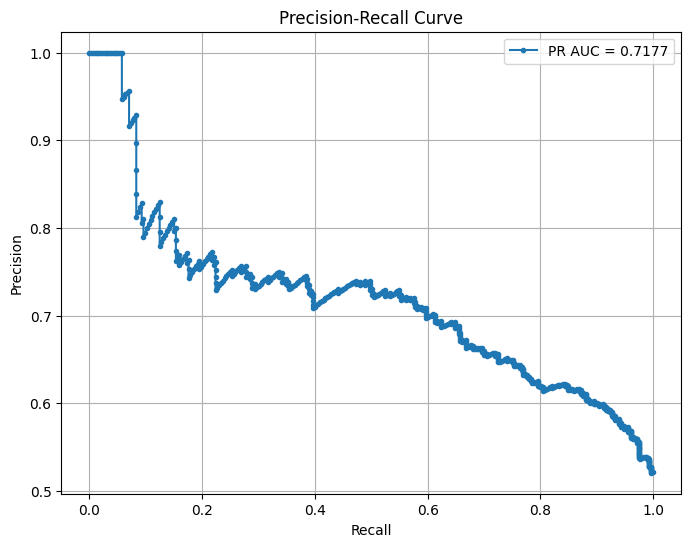

In [ ]:

# Predict Anomalies
y_pred = lstm_gan.predict(test_errors.reshape(-1, 1, 1))
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Compute evaluation metrics
auc_score = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
precision_score_value = precision_score(y_test, y_pred_labels)
recall_score_value = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Print results
print(f"AUC Score: {auc_score:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")
print(f"Precision: {precision_score_value:.4f}")
print(f"Recall: {recall_score_value:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Save AUC Score
with open(f"{results_path}/br35h_auc.txt", "w") as f:
    f.write(f"AUC Score: {auc_score:.3f}")

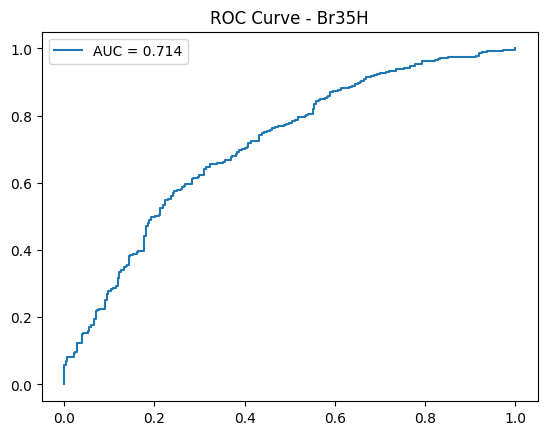

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.legend()
plt.title("ROC Curve - Br35H")
plt.savefig(f"{results_path}/br35h_roc.png")
plt.show()